In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## For Men's

In [2]:
## Reading All the Dataset required for making prediction
teams = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MTeams.csv')
seasons = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv')
trny_seeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv')
reg_sns_cmpt_rst = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonCompactResults.csv')
trny_cmpt_rst = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv')

---
Analyzing the all the datasets one by one
---

In [3]:
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2025
1,1102,Air Force,1985,2025
2,1103,Akron,1985,2025
3,1104,Alabama,1985,2025
4,1105,Alabama A&M,2000,2025


In [4]:
teams.shape

(380, 4)

In [5]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TeamID         380 non-null    int64 
 1   TeamName       380 non-null    object
 2   FirstD1Season  380 non-null    int64 
 3   LastD1Season   380 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.0+ KB


In [6]:
seasons.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/02/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


In [7]:
seasons.isnull().sum()

Season     0
DayZero    0
RegionW    0
RegionX    0
RegionY    0
RegionZ    0
dtype: int64

In [8]:
trny_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [9]:
trny_seeds.shape

(2558, 3)

In [10]:
trny_seeds.isnull().sum()

Season    0
Seed      0
TeamID    0
dtype: int64

In [11]:
reg_sns_cmpt_rst.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [12]:
reg_sns_cmpt_rst.isnull().sum()

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64

In [13]:
trny_cmpt_rst.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [14]:
trny_cmpt_rst.isnull().sum()

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64

-- The Basic analysis clears one thing that there are no nulls present in any of the dataset.

-- Since this is a sports data, there will be some duplicates for sure, due to continous matchup between teams.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


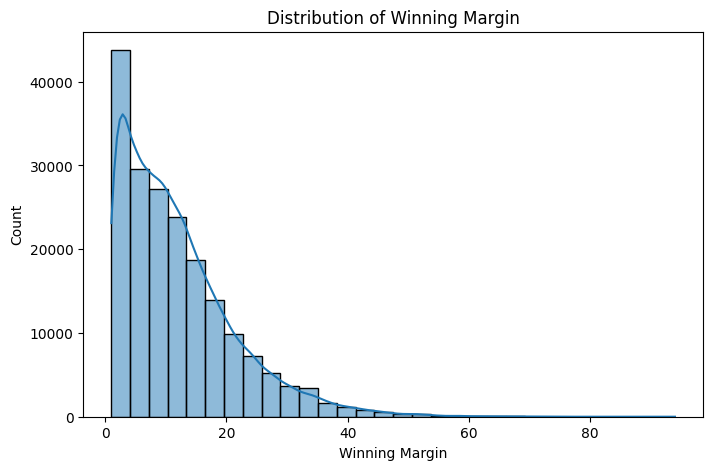

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(reg_sns_cmpt_rst['WScore'] - reg_sns_cmpt_rst['LScore'], bins=30, kde=True)
plt.title("Distribution of Winning Margin")
plt.xlabel("Winning Margin")
plt.show()

## Feature Engineering
To make prediction of the possible team winning, we need to do make the following columns
1. Team Win Rate
2. Average Points Per game
3. Seed Rank

In [16]:
## function for calculating the team winning rate
def compute_win_rate(df):
    win_count = df.groupby("WTeamID").size().reset_index(name="Wins")
    loss_count = df.groupby("LTeamID").size().reset_index(name="Losses")

    team_stats = win_count.merge(loss_count, left_on="WTeamID", right_on="LTeamID", how="outer").fillna(0)
    team_stats["TeamID"] = team_stats["WTeamID"].combine_first(team_stats["LTeamID"])
    
    team_stats["WinRate"] = team_stats["Wins"] / (team_stats["Wins"] + team_stats["Losses"])
    return team_stats[["TeamID", "WinRate"]]

m_team_win_rate = compute_win_rate(reg_sns_cmpt_rst)

In [17]:
m_team_win_rate.head()

,TeamID,WinRate
0,1101,0.469841
1,1102,0.357466
2,1103,0.587383
3,1104,0.631454
4,1105,0.348571


In [18]:
# function for calculating the Average points per game
def compute_avg_points(df):
    win_points = df.groupby("WTeamID")["WScore"].mean().reset_index(name="AvgWinPoints")
    loss_points = df.groupby("LTeamID")["LScore"].mean().reset_index(name="AvgLossPoints")

    team_points = win_points.merge(loss_points, left_on="WTeamID", right_on="LTeamID", how="outer").fillna(0)
    team_points["TeamID"] = team_points["WTeamID"].combine_first(team_points["LTeamID"])
    
    team_points["AvgPoints"] = (team_points["AvgWinPoints"] + team_points["AvgLossPoints"]) / 2
    return team_points[["TeamID", "AvgPoints"]]

m_team_points = compute_avg_points(reg_sns_cmpt_rst)

In [19]:
m_team_points.head()

,TeamID,AvgPoints
0,1101,70.151359
1,1102,65.396078
2,1103,70.425233
3,1104,71.698483
4,1105,67.885659


In [20]:
## Making function for calculating the seeda rank
# Convert seed values (W01, X02, etc.) to numeric values
def process_seeds(trny_seeds):
    trny_seeds["SeedRank"] = trny_seeds["Seed"].str.extract("(\d+)").astype(int)
    return trny_seeds[["Season", "TeamID", "SeedRank"]]

m_seeds_processed = process_seeds(trny_seeds)

In [21]:
m_seeds_processed.head()

,Season,TeamID,SeedRank
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [22]:
missing_seeds = set(reg_sns_cmpt_rst["WTeamID"]) - set(m_seeds_processed["TeamID"])
print("Teams missing seeds:", missing_seeds)

Teams missing seeds: {1152, 1154, 1282, 1410, 1415, 1289, 1162, 1170, 1171, 1302, 1303, 1176, 1430, 1306, 1432, 1312, 1440, 1442, 1188, 1189, 1445, 1446, 1327, 1456, 1464, 1465, 1466, 1467, 1468, 1469, 1342, 1215, 1470, 1471, 1346, 1219, 1472, 1349, 1473, 1223, 1474, 1475, 1476, 1477, 1478, 1357, 1230, 1479, 1480, 1236, 1109, 1366, 1367, 1370, 1118, 1119, 1121, 1377, 1126, 1383, 1128, 1132, 1134, 1262, 1263, 1271, 1146, 1147, 1404, 1405, 1399}


In [23]:
def merge_features(season_results, team_win_rate, team_points, seeds_processed):
    df = season_results.copy()

    df = df.merge(team_win_rate, left_on="WTeamID", right_on="TeamID", how="left").rename(columns={"WinRate": "WWinRate"})
    df.drop(columns=["TeamID"], inplace=True)  # Drop duplicate TeamID

    df = df.merge(team_win_rate, left_on="LTeamID", right_on="TeamID", how="left").rename(columns={"WinRate": "LWinRate"})
    df.drop(columns=["TeamID"], inplace=True)  

    df = df.merge(team_points, left_on="WTeamID", right_on="TeamID", how="left").rename(columns={"AvgPoints": "WAvgPoints"})
    df.drop(columns=["TeamID"], inplace=True)  

    df = df.merge(team_points, left_on="LTeamID", right_on="TeamID", how="left").rename(columns={"AvgPoints": "LAvgPoints"})
    df.drop(columns=["TeamID"], inplace=True)  

    df = df.merge(seeds_processed, left_on=["Season", "WTeamID"], right_on=["Season", "TeamID"], how="left").rename(columns={"SeedRank": "WSeedRank"})
    df.drop(columns=["TeamID"], inplace=True)  

    df = df.merge(seeds_processed, left_on=["Season", "LTeamID"], right_on=["Season", "TeamID"], how="left").rename(columns={"SeedRank": "LSeedRank"})
    df.drop(columns=["TeamID"], inplace=True)  

    # Debugging: Print available columns before accessing 'WSeedRank'
    print("Available columns:", df.columns)

    df["WSeedRank"] = df["WSeedRank"].fillna(20)
    df["LSeedRank"] = df["LSeedRank"].fillna(20)

    df["SeedDiff"] = df["WSeedRank"] - df["LSeedRank"]
    df["WinRateDiff"] = df["WWinRate"] - df["LWinRate"]
    df["PointsDiff"] = df["WAvgPoints"] - df["LAvgPoints"]
    
    return df[["Season", "WTeamID", "LTeamID", "SeedDiff", "WinRateDiff", "PointsDiff", "WScore", "LScore"]]

m_train_data = merge_features(reg_sns_cmpt_rst, m_team_win_rate, m_team_points, m_seeds_processed)

Available columns: Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WWinRate', 'LWinRate', 'WAvgPoints', 'LAvgPoints',
       'WSeedRank', 'LSeedRank'],
      dtype='object')


In [24]:
m_train_data.head()

,Season,WTeamID,LTeamID,SeedDiff,WinRateDiff,PointsDiff,WScore,LScore
0,1985,1228,1328,2.0,-0.010437,-4.169302,81,64
1,1985,1106,1354,0.0,-0.018970,1.287990,77,70
2,1985,1112,1223,-10.0,0.456969,3.155311,63,56
3,1985,1165,1432,0.0,0.029656,2.467857,70,54
4,1985,1192,1447,-4.0,-0.028017,0.599122,86,74


In [25]:
m_train_data.shape

(191796, 8)

In [26]:
m_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191796 entries, 0 to 191795
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Season       191796 non-null  int64  
 1   WTeamID      191796 non-null  int64  
 2   LTeamID      191796 non-null  int64  
 3   SeedDiff     191796 non-null  float64
 4   WinRateDiff  191796 non-null  float64
 5   PointsDiff   191796 non-null  float64
 6   WScore       191796 non-null  int64  
 7   LScore       191796 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 11.7 MB


In [27]:
m_train_data.describe()

,Season,WTeamID,LTeamID,SeedDiff,WinRateDiff,PointsDiff,WScore,LScore
count,191796.000000,191796.000000,191796.000000,191796.000000,191796.000000,191796.000000,191796.000000,191796.000000
mean,2006.271257,1287.599757,1283.342286,-2.292295,0.042872,0.364699,76.855664,64.771205
std,11.623911,104.920419,105.102958,5.985716,0.117313,2.807199,11.833224,11.201711
min,1985.000000,1101.000000,1101.000000,-19.000000,-0.453670,-19.585925,34.000000,20.000000
25%,1996.000000,1199.000000,1191.000000,-4.000000,-0.036364,-1.356330,69.000000,57.000000
50%,2007.000000,1285.000000,1281.000000,0.000000,0.040243,0.303698,76.000000,64.000000
75%,2016.000000,1380.000000,1375.000000,0.000000,0.117541,2.123277,84.000000,72.000000
max,2025.000000,1480.000000,1480.000000,19.000000,0.559362,19.585925,186.000000,150.000000


In [28]:
m_train_data.to_csv("Processed_Men_Train.csv", index=False)

In [29]:
m_train_data["WTeamWin"] = 1  # Winning team labeled as 1
m_train_data["LTeamWin"] = 0  # Losing team labeled as 0

In [30]:
df_wins = m_train_data[["Season", "WTeamID", "LTeamID", "SeedDiff", "WinRateDiff", "PointsDiff", "WTeamWin"]]
df_losses = m_train_data[["Season", "LTeamID", "WTeamID", "SeedDiff", "WinRateDiff", "PointsDiff", "LTeamWin"]]

df_wins.columns = ["Season", "Team1", "Team2", "SeedDiff", "WinRateDiff", "PointsDiff", "Win"]
df_losses.columns = ["Season", "Team1", "Team2", "SeedDiff", "WinRateDiff", "PointsDiff", "Win"]

In [31]:
df_full = pd.concat([df_wins, df_losses])

df_full.dropna(inplace=True)  # Remove missing values

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import brier_score_loss

In [33]:
X = df_full[["SeedDiff", "WinRateDiff", "PointsDiff"]]
y = df_full["Win"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

best_model = None
best_score = float("inf")

In [35]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    score = brier_score_loss(y_test, y_pred)
    print(f"{name} Brier Score: {score}")
    
    if score < best_score:
        best_score = score
        best_model = model

print(f"Best Model: {best_model}")

Logistic Regression Brier Score: 0.250008626573995
Random Forest Brier Score: 0.38554182006459853
XGBoost Brier Score: 0.2559581424339882
Best Model: LogisticRegression(max_iter=1000)


In [36]:
if isinstance(best_model, RandomForestClassifier):
    param_grid = {"n_estimators": [100, 200, 300], "max_depth": [5, 10, 20]}
elif isinstance(best_model, XGBClassifier):
    param_grid = {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1]}
elif isinstance(best_model, LogisticRegression):
    param_grid = {"C": [0.1, 1, 10]}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_brier_score')
grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)

Best Params: {'C': 0.1}


In [37]:
prediction_df = pd.read_csv("/kaggle/input/march-machine-learning-mania-2025/SampleSubmissionStage1.csv")
prediction_df[["Season", "Team1", "Team2"]] = prediction_df["ID"].str.split("_", expand=True)
prediction_df[["Season", "Team1", "Team2"]] = prediction_df[["Season", "Team1", "Team2"]].astype(int)

In [38]:
prediction_df.head()

,ID,Pred,Season,Team1,Team2
0,2021_1101_1102,0.5,2021,1101,1102
1,2021_1101_1103,0.5,2021,1101,1103
2,2021_1101_1104,0.5,2021,1101,1104
3,2021_1101_1105,0.5,2021,1101,1105
4,2021_1101_1106,0.5,2021,1101,1106


In [39]:
# Merge Seeds (fill missing values with "W01")
prediction_df = prediction_df.merge(m_seeds_processed, left_on=["Season", "Team1"], right_on=["Season", "TeamID"], how="left").rename(columns={"SeedRank": "Seed1"})
prediction_df = prediction_df.merge(m_seeds_processed, left_on=["Season", "Team2"], right_on=["Season", "TeamID"], how="left").rename(columns={"SeedRank": "Seed2"})
prediction_df.drop(columns=["TeamID_x", "TeamID_y"], inplace=True)
prediction_df.fillna({"Seed1": 16, "Seed2": 16}, inplace=True)

In [40]:
# Merge Team Stats (Win Rate, Avg Points, etc.)
prediction_df = prediction_df.merge(m_team_win_rate, left_on="Team1", right_on="TeamID", how="left").rename(columns={"WinRate": "WinRate1"}).drop(columns=["TeamID"])
prediction_df = prediction_df.merge(m_team_win_rate, left_on="Team2", right_on="TeamID", how="left").rename(columns={"WinRate": "WinRate2"}).drop(columns=["TeamID"])

prediction_df = prediction_df.merge(m_team_points, left_on="Team1", right_on="TeamID", how="left").rename(columns={"AvgPoints": "AvgPoints1"}).drop(columns=["TeamID"])
prediction_df = prediction_df.merge(m_team_points, left_on="Team2", right_on="TeamID", how="left").rename(columns={"AvgPoints": "AvgPoints2"}).drop(columns=["TeamID"])

In [41]:
# Compute Feature Differences
prediction_df["SeedDiff"] = prediction_df["Seed1"] - prediction_df["Seed2"]
prediction_df["WinRateDiff"] = prediction_df["WinRate1"] - prediction_df["WinRate2"]
prediction_df["PointsDiff"] = prediction_df["AvgPoints1"] - prediction_df["AvgPoints2"]

In [42]:
X_test = prediction_df[["SeedDiff", "WinRateDiff", "PointsDiff"]].fillna(0)

# Make predictions
prediction_df["Pred"] = best_model.predict_proba(X_test)[:, 1]

# Fill NaN predictions with 0.5 (since match is not played)
prediction_df["Pred"].fillna(0.5, inplace=True)

# Prepare submission file
submission_df = prediction_df[["ID", "Pred"]]
submission_df.to_csv("submission.csv", index=False)

<ipython-input-42-e33dbec49c6a>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prediction_df["Pred"].fillna(0.5, inplace=True)


In [43]:
submission_df.head()

,ID,Pred
0,2021_1101_1102,0.498286
1,2021_1101_1103,0.499735
2,2021_1101_1104,0.500533
3,2021_1101_1105,0.499013
4,2021_1101_1106,0.499845
